In [2]:
# Memory Allocation for using GPU 
import tensorflow as tf 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import metrics

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import os

1 Physical GPUs, 1 Logical GPUs


## Load Dataset

In [14]:
BASE_PATH = os.path.abspath(".")
DATA_PATH = os.path.abspath("..\\..\\00_MLDL\\00_BreadBrother\\06_Breast_Cancer\\")

# csv read
data = pd.read_csv(os.path.join(DATA_PATH, "datasets_180_408_data.csv"))
# Head 출력
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

## Refine Dataset

In [15]:
data.drop(["id", "Unnamed: 32"], axis=1, inplace=True)
"""
Benign : 양성(0)
Malignant : 악성(1)
"""
data["diagnosis"] = data["diagnosis"].map({"B":0, "M":1})
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [17]:
data.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


<AxesSubplot:xlabel='diagnosis', ylabel='count'>

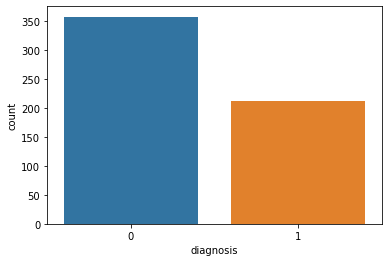

In [19]:
sns.countplot(data["diagnosis"])

## Split Train and Test

In [47]:
train, test = train_test_split(data, test_size=0.2, random_state=2019) # random_state는 seed가 있어서 data randomization이 고정되어 있음(Train, Test data 고정됨)

x_train = train.drop(["diagnosis"], axis=1)
y_train = train.diagnosis

x_test = test.drop(["diagnosis"], axis=1)
y_test = test.diagnosis

print(f"Training length: {len(train)}\nTest length: {len(test)}")

Training length: 455
Test length: 114


### SVM(Support Vector Machine)

In [65]:
model = svm.SVC(gamma="scale")
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(f"SVM Acc. {metrics.accuracy_score(y_pred, y_test) * 100:.2f}[%]")

SVM Acc. 91.23[%]


### LogsticRegreesion

In [70]:
model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(f"Logistic Regreesion Acc. {metrics.accuracy_score(y_pred, y_test) * 100:.2f}[%]")

Logistic Regreesion Acc. 93.86[%]


### KNeighborsClassifier

In [103]:
model = KNeighborsClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(f"KNeighborsClassifier Acc. {metrics.accuracy_score(y_pred, y_test) * 100:.2f}[%]")

KNeighborsClassifier Acc. 92.98[%]


### RandomForestClassifier

In [104]:
model = RandomForestClassifier() # n_estimator default = 100
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

# Accuracy variable
print(f"RandomForestClassifier Acc. {metrics.accuracy_score(y_pred, y_test) * 100:.2f}[%]")


RandomForestClassifier Acc. 93.86[%]


## Compute Feature Importances

In [106]:
features = pd.Series(
    model.feature_importances_,
    index=x_train.columns
    ).sort_values(ascending=False)

print(features)

concave points_worst       0.186069
perimeter_worst            0.124758
area_worst                 0.106532
radius_worst               0.105216
concave points_mean        0.090491
concavity_mean             0.056928
perimeter_mean             0.054270
area_mean                  0.053173
concavity_worst            0.032012
radius_mean                0.029687
radius_se                  0.022641
area_se                    0.021965
compactness_worst          0.016426
perimeter_se               0.012418
symmetry_worst             0.010898
texture_worst              0.010276
smoothness_worst           0.008189
fractal_dimension_worst    0.007721
texture_mean               0.007686
compactness_mean           0.007543
smoothness_mean            0.005402
smoothness_se              0.004931
compactness_se             0.003866
fractal_dimension_se       0.003486
texture_se                 0.003343
fractal_dimension_mean     0.003179
concave points_se          0.003118
symmetry_se                0

## Extract Top 5 Features

In [111]:
top5_features = features.keys()[:5]
print(top5_features)

Index(['concave points_worst', 'perimeter_worst', 'area_worst', 'radius_worst',
       'concave points_mean'],
      dtype='object')


### SVM(Top 5)

In [115]:
model = svm.SVC(gamma="scale")
model.fit(x_train[top5_features], y_train)

y_pred = model.predict(x_test[top5_features])
print(f"SVM Top5 Features Acc. {metrics.accuracy_score(y_pred, y_test) * 100:.2f}[%]")


SVM Top5 Features Acc. 91.23[%]


## Cross Validation (Tedious)
![CV Description](https://github.com/yhhyunn/learn_ML_basic/raw/master/Images/CV.png)

In [119]:
model = svm.SVC(gamma="scale")

cv = KFold(n_splits=5, random_state=2019) # Data divided by 5

accs, scores = [], []

for train_idx, test_idx in cv.split(data[top5_features]): 
    x_train = data.iloc[train_idx][top5_features] # Order: row,, columns(top5 features) (114*4 , 5)
    y_train = data.iloc[train_idx].diagnosis # Order: row, column('diagnosis') (114*4, 1)

    x_test = data.iloc[test_idx][top5_features] # (114,5)
    y_test = data.iloc[test_idx].diagnosis # (114,1)

    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    accs.append(metrics.accuracy_score(y_test, y_pred))

print(accs)

[0.7807017543859649, 0.8947368421052632, 0.9736842105263158, 0.9298245614035088, 0.9380530973451328]


## Cross Validation (Simple)

In [122]:
model = svm.SVC(gamma="scale")

cv = KFold(n_splits=5, random_state=2019)

accs = cross_val_score(model, data[top5_features], data.diagnosis, cv=cv)

print(accs)

[0.78070175 0.89473684 0.97368421 0.92982456 0.9380531 ]


Test All Models

In [126]:
models = {
    "SVM": svm.SVC(gamma="scale"),
    "LogisticRegression": LogisticRegression(solver="lbfgs", max_iter=2000),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

cv = KFold(n_splits=5, random_state=2019)

for name, model in models.items():
    scores = cross_val_score(model, data[top5_features], data.diagnosis, cv=cv)
    print(f"{name}: {np.mean(scores) * 100:.2f}[%]")

SVM: 90.34[%]
LogisticRegression: 90.69[%]
KNeighborsClassifier: 88.40[%]
RandomForestClassifier: 93.33[%]
DecisionTreeClassifier: 90.50[%]


## Normalize Dataset

In [128]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[top5_features]) # column data normalization

models = {
    "SVM": svm.SVC(gamma="scale"),
    "LogisticRegression": LogisticRegression(solver="lbfgs", max_iter=2000),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

cv = KFold(n_splits=5, random_state=2019)

for name, model in models.items():
    scores = cross_val_score(model, scaled_data, data.diagnosis, cv=cv)
    print(f"{name}: {np.mean(scores) * 100:.2f}[%]")

SVM: 93.85[%]
LogisticRegression: 93.85[%]
KNeighborsClassifier: 93.15[%]
RandomForestClassifier: 93.33[%]
DecisionTreeClassifier: 91.03[%]
